In [2]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import logging
import importlib

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from itertools import product

from numpy.typing import NDArray


In [3]:
# import theory stuff
sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from theory.models import get_I_nA
from theory.models import get_I_nA_dynes
from theory.models import get_I_nA_HA
from theory.models import get_I_nA_FCS
from theory.models import get_I_nA_FCS_pbar
from theory.models import get_I_nA_PAT
from theory.models import get_I_nA_PAMAR
from theory.models import get_tien_gordon_pamar

from theory.models import bin_y_over_x

from theory.models import G_0_muS, e, h

importlib.reload(sys.modules["theory.models"])

<module 'theory.models' from '/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/__init__.py'>

In [ ]:
# get cpd colors
from utilities.corporate_design_colors_v4 import cmap
from utilities.corporate_design_colors_v4 import DATABASE

importlib.reload(sys.modules["utilities.corporate_design_colors_v4"])

colors = []
color_keys = [
    "seeblau",
    "peach",
    "grau",
    "petrol",
    "seegrün",
    "karpfenblau",
    "pinky",
    "bordeaux",
]
# color_keys = ['seeblau', 'amber', 'magenta', 'mint', 'lila', 'lime']
for i in range(5):
    for color_key in color_keys:
        database = DATABASE[color_key]
        index = database["leading color"][i]
        colors.append(
            (
                max(0, database["R"][index]),
                max(0, database["G"][index]),
                max(0, database["B"][index]),
            )
        )

import matplotlib.colors as mcolors


def lighten_color(color, amount=0.5):
    """
    Lighten a given color by blending it with white.

    Parameters:
    - color: Matplotlib color string, hex, or RGB tuple
    - amount: 0 (no change) to 1 (fully white)

    Returns:
    - Lightened RGB tuple
    """
    try:
        c = mcolors.to_rgb(color)
    except ValueError:
        raise ValueError(f"Invalid color: {color}")

    white = np.array([1.0, 1.0, 1.0])
    return tuple((1 - amount) * np.array(c) + amount * white)

# Testing Ground

In [ ]:
# handle V-axis
V_exp_mV = np.linspace(-0.1, 0.8, 451, dtype="float64")
V_mV: NDArray = np.linspace(0, 0.7, 351, dtype="float64")

V_mV = np.where(V_mV == 0, np.nan, V_mV)
V_mask = np.logical_not(np.isnan(V_mV))
VV_mV = np.concatenate((V_mV, V_mV), dtype="float64")

In [ ]:
# jit stuff
%reload_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import jit, Array

from theory.models.dynes_jnp import currents, thermal_energy_gap
importlib.reload(sys.modules["theory.models.dynes_jnp"])

V_exp_mV_jax: Array = jnp.array(V_exp_mV)

# @jit
def get_dynes(xdata: NDArray, window:tuple[int, int], tau:float, T_K:float, Delta_meV:float, Gamma_meV:float) -> Array:
    V_meV: NDArray = np.array(xdata[:int(xdata.shape[0]/2)], dtype='float64')
    V_mV = np.copy(V_meV)
    V_mV[V_mV==0] = np.nan

    Delta_meV_T: float = float(
        thermal_energy_gap(
            Delta_meV=Delta_meV, 
            T_K=T_K
            )
        )
    
    I_meV: Array = currents(
        V_meV=V_exp_mV_jax,
        T_K=T_K,
        Delta_meV=Delta_meV_T,
        Gamma_meV=Gamma_meV,
    )
    I_mV: NDArray = tau * np.array(I_meV, dtype='float64')
    if window[0] > 2:
        I_mV = savgol_filter(I_mV, window[0], 2)

    G:    NDArray = np.gradient(I_mV, V_exp_mV)
    if window[1] > 2:
        G    = savgol_filter(G   , window[1], 2)

    I_mV = bin_y_over_x(V_exp_mV, I_mV, V_mV)
    G    = bin_y_over_x(V_exp_mV, G,    V_mV)
    
    g = I_mV / V_mV # V_mV shouldn't contain 0.0
    return jnp.concatenate((g, G), dtype='float64')

from collections.abc import Callable

def make_fixed_param_model(model:Callable, p0:NDArray, fixed:NDArray) -> Callable:
    """
    Returns a function f_free(x, *free_params) where fixed params are filled from p0
    """
    def f_free(x, *free_params):
        full_params = p0.copy()
        full_params[~fixed] = free_params
        return model(x, *full_params)
    return f_free

In [ ]:
# Get exp data
from utilities.ivplot import IVPlot

importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.file_directory = "/Users/oliver/Documents/measurement data/"
eva.file_folder = "25 04 OI-25c-09/unbroken/"
eva.file_name = "OI-25c-09 2025-04-15 unbroken 1.hdf5"
eva.title = "fitting study"
eva.sub_folder = ""

eva.setAmplifications(1000, 1000)
eva.setV(
    voltage_minimum=np.min(V_exp_mV) * 1e-3,
    voltage_maximum=np.max(V_exp_mV) * 1e-3,
    voltage_bins=len(V_exp_mV) - 1,
)
eva.setI(current_minimum=-0.1e-8, current_maximum=0.8e-8, current_bins=900)
eva.setT(0.2, 1.4, 240)
eva.downsample_frequency = 137

# eva.showMeasurements()

eva.setMeasurement("temperatures")
eva.showKeys()
eva.setKeys(index_0=7, index_1=-3, norm=1e-6, to_pop="no_heater")
(eva.up_sweep,) = eva.getMaps([1])

(eva.up_sweep,) = eva.getMapsTemperature([eva.up_sweep])
eva.y_axis = eva.temperature_axis
eva.saveData()

100%|██████████| 150/150 [01:27<00:00,  1.71it/s]


In [ ]:
indices: list[int] = [11]
window: tuple[int, int] = (10, 20)
p0: NDArray = np.array(
    [
        0.18861238619219342,  # 0.00019309203594486266
        0.33693467633739194,  # 0.001850703935763906
        0.1954362246372233,  # 0.0007956272492040607
        0.011287765772955006,  # 6.318067323754672e-06
    ]
)
bounds: tuple[NDArray, NDArray] = (
    np.array([0.150, 0, 180e-3, 1e-3]),
    np.array([0.250, 2, 205e-3, 25e-3]),
)
fixed: NDArray = np.array([True, False, False, False])
maxfev: int = 10000  # def. 800

In [ ]:
# load and recalculate exp data
from utilities.ivplot import IVPlot

importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.title = "fitting study"
eva.sub_folder = ""
eva.loadData()

# Recalculate calibrated exp data
I_exp_raw: NDArray = np.array(eva.up_sweep["current"] * 1e9, dtype="float64")
# G_exp_raw: NDArray = eva.up_sweep["differential_conductance"]

if window[0] > 2:
    I_exp_raw: NDArray = savgol_filter(I_exp_raw, window[0], 2)

G_exp_raw: NDArray = (
    np.array(np.gradient(I_exp_raw, V_exp_mV, axis=1), dtype="float64") / G_0_muS
)

if window[1] > 2:
    G_exp_raw = savgol_filter(G_exp_raw, window[1], 2)

I_exp = np.full_like(V_mV, 0, dtype="float64")
G_exp = np.full_like(V_mV, 0, dtype="float64")
for index in indices:
    I_exp[V_mask] += bin_y_over_x(V_exp_mV, I_exp_raw[index, :], V_mV[V_mask])
    G_exp[V_mask] += bin_y_over_x(V_exp_mV, G_exp_raw[index, :], V_mV[V_mask])
I_exp = np.where(I_exp == 0.0, np.nan, I_exp)
G_exp = np.where(G_exp == 0.0, np.nan, G_exp)

g_exp = np.where(V_mask, I_exp / (G_0_muS * V_mV), np.nan)
print(f'Got data for T_cal = {eva.mapped["temperature_axis"][indices]} K.')

Got data for T_cal = [0.255] K.


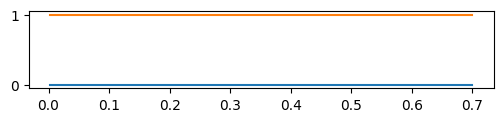

In [34]:
# sigma distribution
sigma_G = 1-np.exp(-.5*(V_mV-2*p0[2])**2/((.25*p0[2])**2))
sigma_g = (1-.1*np.tanh(V_mV/(2*p0[2])))*np.exp(-.5*(V_mV-p0[2])**2/((.5*p0[2])**2))
sigma_g /= np.nanmax(sigma_g)
sigma_g = 1-sigma_g
sigma_g += .01/V_mV
# sigma_g = np.where(sigma_g>1, 1, sigma_g)
# sigma_g = np.where(V_mV<.5*p0[2], 1.0, sigma_g)

sigma_g=np.full_like(V_mV, 0.001)
sigma_G=np.full_like(V_mV, 1.0)

%matplotlib inline
plt.close('all')
plt.figure(1, figsize=(6,1))
plt.plot(V_mV, sigma_g)
plt.plot(V_mV, sigma_G)


In [ ]:
# perform fit
xdata = np.concatenate((V_mV[V_mask], V_mV[V_mask]), dtype="float64")
ydata = np.concatenate((g_exp[V_mask], G_exp[V_mask]), dtype="float64")

sigma = np.concatenate((sigma_g[V_mask], sigma_G[V_mask]), dtype="float64")
sigma = np.where(sigma == 0, np.finfo(float).eps, sigma)
sigma = np.where(sigma == 1, 1 - np.finfo(float).eps, sigma)

# get init current
g_init, G_init = np.full_like(V_mV, np.nan), np.full_like(V_mV, np.nan)
g_init[V_mask], G_init[V_mask] = np.array_split(
    get_dynes(xdata, window, *p0), 2, axis=0
)
ug_init = g_init - g_exp
uG_init = G_init - G_exp
ug_init = np.where(ug_init >= 0, ug_init**2, -1 * ug_init**2)
uG_init = np.where(uG_init >= 0, uG_init**2, -1 * uG_init**2)
I_init = g_init * G_0_muS * V_mV

# Build wrapped model with fixed parameter support
get_dynes_fixed = make_fixed_param_model(get_dynes, p0, fixed, window)

# Extract initial init and bounds only for free parameters
p0_free = p0[~fixed]
bounds_free = (bounds[0][~fixed], bounds[1][~fixed])

popt_free, pcov_free = curve_fit(
    f=get_dynes_fixed,
    xdata=xdata,
    ydata=ydata,
    sigma=sigma,
    absolute_sigma=True,
    p0=p0_free,
    bounds=bounds_free,
    maxfev=maxfev,  # def. 800
)
perr_free = np.sqrt(np.diag(pcov_free))

# Reconstruct full popt including fixed values
popt = p0.copy()
popt[~fixed] = popt_free

perr = np.full_like(p0, 0)
perr[~fixed] = perr_free

g_fit, G_fit = np.full_like(V_mV, np.nan), np.full_like(V_mV, np.nan)
g_fit[V_mask], G_fit[V_mask] = np.array_split(
    get_dynes(xdata, window, *popt), 2, axis=0
)
ug_fit = g_fit - g_exp
uG_fit = G_fit - G_exp
ug_fit = np.where(ug_fit >= 0, ug_fit**2, -1 * ug_fit**2)
uG_fit = np.where(uG_fit >= 0, uG_fit**2, -1 * uG_fit**2)
I_fit = g_fit * G_0_muS * V_mV


print(f"tau = {popt[0]:.5f} ({int(perr[0]*1e5)})")
print(f"T = {popt[1]*1e3:.1f} ({int(perr[1]*1e4)}) mK")
print(f"Delta = {popt[2]*1e3:.2f} ({int(perr[2]*1e5)}) µeV")
print(f"Gamma = {popt[3]*1e3:.3f} ({int(perr[3]*1e6)}) µeV")

# popt, perr

/Users/oliver/Documents/p5control-bluefors-evaluation/.venv/lib/python3.13/site-packages/jax/_src/numpy/lax_numpy.py:4620: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  arrays_out = [asarray(arr, dtype=dtype) for arr in arrays]


tau = 0.18861 (0)
T = 353.0 (27) mK
Delta = 196.04 (5) µeV
Gamma = 7.391 (44) µeV


In [36]:
# show fitting procedure
%matplotlib qt
plt.close(0)
fig, axs = plt.subplots(
    num=0,
    nrows=5, sharex=True, height_ratios=(2, 1,1,1,1), figsize=(6,9)
    )
fig.subplots_adjust(hspace=0.1, wspace=0.05)

def VtoE(V_mV): return V_mV / p0[2]
def EtoV(E_meV): return E_meV * p0[2]
axs_2=[]
for ax in axs:
    ax.tick_params(
            direction='in',       # Ticks nach innen
            top=False,             # obere Ticks ein
            bottom=True,          # untere Ticks ein
            left=True,            # linke Ticks ein
            right=False,           # rechte Ticks ein
            which='both'          # sowohl Major- als auch Minor-Ticks
        )
    ax.grid()
    ax.tick_params(labelbottom=False)
    ax_2 = ax.secondary_xaxis("top", functions=(VtoE, EtoV))
    ax_2.tick_params(direction='in', top=True)
    ax_2.tick_params(labeltop=False)
    axs_2.append(ax_2)
axs_2[0].tick_params(labeltop=True)
axs[-1].tick_params(labelbottom=True)

(ax_I, ax_g, ax_G, ax_ug, ax_uG) = axs
(ax_I_2, ax_g_2, ax_G_2, ax_ug_2, ax_uG_2) = axs_2
axs_s = []
for ax in [ax_ug, ax_uG]:
    ax_s = ax.twinx()
    ax_s.tick_params(axis='y', labelcolor='grey', direction='in', color='grey')
    ax_s.set_ylabel('$\\sigma$ (arb. u.)', color='grey')
    ax_s.set_ylim((-.1, 1.1))
    axs_s.append(ax_s)

def G_to_(x): return x / p0[0]
def _to_G(x): return x * p0[0]
axs_ = []
for ax in [ax_g, ax_G]:
    ax_ = ax.secondary_yaxis("right", functions=(G_to_, _to_G))
    ax_.tick_params(direction='in', right=True)
    ax_.tick_params(labelleft=False)
    axs_.append(ax_)

def I_nA_to_I_(x): return x / (1e-9 * 2*e/h * p0[2]*1e-3)
def I__to_I_nA(x): return x * (1e-9 * 2*e/h * p0[2]*1e-3)
ax_I_ = ax_I.secondary_yaxis("right", functions=(I_nA_to_I_, I__to_I_nA))
ax_I_.tick_params(direction='in', right=True)
ax_I_.tick_params(labelleft=False)

ax_I_2.set_xlabel('$E$ ($\\Delta_\\mathrm{init}$)')
ax_uG.set_xlabel('$V$ (mV)')

ax_I.set_ylabel("$I$ (nA)")
ax_I_.set_ylabel("$I$ ($2e/h \\cdot \\Delta_\\mathrm{init}$)")
ax_g.set_ylabel('$I/V$ ($G_0$)')
axs_[0].set_ylabel('$I/V$ ($G_\\mathrm{init}$)')
ax_G.set_ylabel('d$I/$d$V$ ($G_0$)')
axs_[1].set_ylabel('d$I/$d$V$ ($G_\\mathrm{init}$)')
ax_ug.set_ylabel('$\\sigma\\cdot u_{I/V}$ ($G_0^2$)')
ax_uG.set_ylabel('$\\sigma\\cdot u_{\\mathrm{d}I/\\mathrm{d}V}$ ($G_0^2$)')
# axs_s[0].set_ylabel('$w_{I/V}$ (arb. u.)', color='grey')
# axs_s[1].set_ylabel('$w_{\\mathrm{d}I/\\mathrm{d}V}$', color='grey')

ax_I.plot(V_mV, I_exp, '.', label='$\\mathrm{exp}$', color=colors[3], ms=2, zorder=13)
ax_I.plot(V_mV, I_fit, label='$\\mathrm{fit}$', color=colors[0], zorder=12)
ax_I.plot(V_mV, I_init, label='$\\mathrm{init}$', color=colors[4], zorder=11)
ax_I.legend()

ax_g.plot(V_mV, g_exp, '.', color=colors[3], ms=2, zorder=13)
ax_g.plot(V_mV, g_fit, color=colors[0], zorder=12)
ax_g.plot(V_mV, g_init, color=colors[4], zorder=11)

ax_G.plot(V_mV, G_exp, '.', color=colors[3], ms=2, zorder=13)
ax_G.plot(V_mV, G_fit, color=colors[0], zorder=12)
ax_G.plot(V_mV, G_init, color=colors[4], zorder=11)

ax_ug.plot(V_mV, np.zeros_like(g_exp), '.', color=colors[3], ms=2, zorder=13)
ax_ug.plot(V_mV, sigma_g * ug_fit, color=(colors[0]), zorder=12)
ax_ug.plot(V_mV, sigma_g * ug_init, color=(colors[4]), zorder=11)
ax_ug_y_lim = ax_ug.get_ylim()
ax_ug.plot(V_mV, ug_fit, color=lighten_color(colors[0]), zorder=10)
ax_ug.plot(V_mV, ug_init, color=lighten_color(colors[4]), zorder=9)
ax_ug.set_ylim(ax_ug_y_lim)

ax_uG.plot(V_mV, np.zeros_like(G_exp), '.', color=colors[3], ms=2, zorder=13)
ax_uG.plot(V_mV, sigma_G * uG_fit, color=(colors[0]), zorder=12)
ax_uG.plot(V_mV, sigma_G * uG_init, color=(colors[4]), zorder=11)
ax_uG_y_lim = ax_uG.get_ylim()
ax_uG.plot(V_mV, uG_fit, color=lighten_color(colors[0]), zorder=10)
ax_uG.plot(V_mV, uG_init, color=lighten_color(colors[4]), zorder=9)
ax_uG.set_ylim(ax_uG_y_lim)

# ylim = (min(ax_uG_y_lim[0], ax_ug_y_lim[0]), max(ax_uG_y_lim[1], ax_ug_y_lim[1]))
# ax_uG.set_ylim(ylim)
# ax_ug.set_ylim(ylim)

axs_s[0].plot(V_mV, sigma_g, color='grey')
axs_s[1].plot(V_mV, sigma_G, color='grey')

# add text box for the statistics
stats = ''
stats += f'$G={popt[0]:.4f}$'
stats += f'$\\,({int(np.round(perr[0]*1e4))})$' if perr[0]!=0 else ''
stats += f'$\\,G_0$\n'
stats += f'$T={popt[1]*1e3:.1f}$'
stats += f'$\\,({int(np.round(perr[1]*1e4))})$' if perr[1]!=0 else ''
stats += f'$\\,$mK\n'
stats += f'$\\Delta={popt[2]*1e3:.1f}$'
stats += f'$\\,({int(np.round(perr[2]*1e4))})$' if perr[2]!=0 else ''
stats += f'$\\,$µeV\n'
stats += f'$\\Gamma={popt[3]*1e3:.2f}$'
stats += f'$\\,({int(np.round(perr[3]*1e5))})$' if perr[3]!=0 else ''
stats += f'$\\,$µeV'
bbox = dict(boxstyle='round', fc='lightgrey', ec='grey', alpha=0.5)
ax_I.text(0.05, .6, stats, fontsize=9, bbox=bbox,
        transform=ax_I.transAxes, horizontalalignment='left')

fig.tight_layout()

In [ ]:
# plt.savefig('fitter_fix_T_Gamma.png')

In [31]:
popt[1]

np.float64(0.33346012175065864)